In [ ]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import itertools
import seaborn as sns
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.metrics import f1_score
from keras.optimizers import RMSprop,Adam
from sklearn.metrics import confusion_matrix
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
uploaded = files.upload()

importing dataset

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d gti-upm/leapgestrecog

In [ ]:
!unzip leapgestrecog.zip

In [ ]:
base_data_dir = "/content/leapGestRecog"
gestures = ["01_palm", "02_l", "03_fist", "04_fist_moved", "05_thumb", "06_index", "07_ok", "08_palm_moved", "09_c", "10_down"]
data = []
image_size = (50, 50)

for subject in range(10):
    subject_data_dir = os.path.join(base_data_dir, f"{subject:02d}")
    for gesture in gestures:
        gesture_dir = os.path.join(subject_data_dir, gesture)
        if os.path.exists(gesture_dir):
            for filename in os.listdir(gesture_dir):
                if filename.endswith(".png"):
                    image_path = os.path.join(gesture_dir, filename)
                    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
                    resized_image = cv2.resize(image, image_size)
                    data.append({"gesture": gesture, "image": resized_image})

total_data_count = len(data)
print(f"Total samples: {total_data_count}")

Total samples: 20000


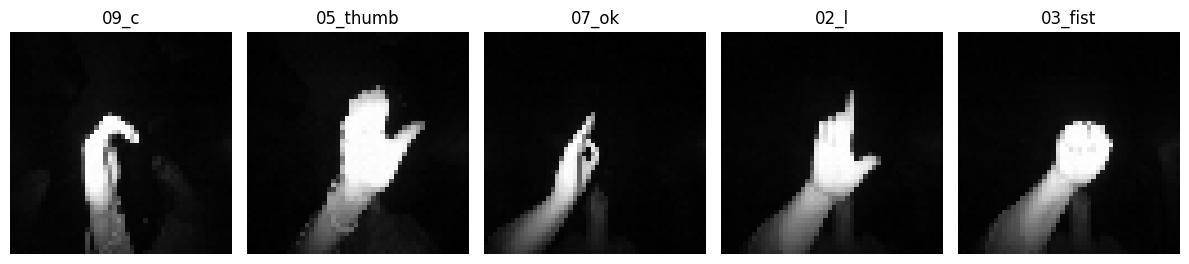

In [ ]:
num_samples_to_display = 5
plt.figure(figsize=(12, 8))

for i in range(num_samples_to_display):
    random_index = random.randint(0, len(data) - 1)
    sample = data[random_index]
    gesture = sample['gesture']
    image = sample['image']

    plt.subplot(1, num_samples_to_display, i + 1)
    plt.imshow(image, cmap='gray')
    plt.title(gesture)
    plt.axis('off')

plt.tight_layout()
plt.show()

Train, test data generation

In [ ]:
df = pd.DataFrame(data)
X_train = np.array(df['image'].tolist())

X_train = X_train.reshape(-1, 50, 50, 1)
X_train = X_train / 255.0

Y_train = df['gesture']

print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)

X_train shape: (20000, 50, 50, 1)
Y_train shape: (20000,)


In [ ]:
label_encoder = LabelEncoder()
numerical_labels = label_encoder.fit_transform(Y_train)

onehot_encoder = OneHotEncoder(sparse_output=False)
onehot_labels = onehot_encoder.fit_transform(numerical_labels.reshape(-1, 1))

X_train, X_val, onehot_labels_train, onehot_labels_val = train_test_split(X_train, onehot_labels, test_size=0.1, random_state=2)

#Model

In [ ]:
model = Sequential()
model.add(Conv2D(filters = 8, kernel_size = (5,5), activation ='relu', input_shape = (50,50,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 16, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

epochs = 10
batch_size = 250

model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

Training

In [ ]:
history = model.fit(X_train, onehot_labels_train, batch_size=batch_size,
                    epochs=epochs, validation_data=(X_val, onehot_labels_val))

Epoch 1/10
72/72 [==============================] - 32s 425ms/step - loss: 1.3101 - accuracy: 0.5610 - val_loss: 0.4582 - val_accuracy: 0.8870
Epoch 2/10
72/72 [==============================] - 24s 330ms/step - loss: 0.4274 - accuracy: 0.8602 - val_loss: 0.1373 - val_accuracy: 0.9745
Epoch 3/10
72/72 [==============================] - 23s 324ms/step - loss: 0.2136 - accuracy: 0.9326 - val_loss: 0.0545 - val_accuracy: 0.9945
Epoch 4/10
72/72 [==============================] - 23s 310ms/step - loss: 0.1326 - accuracy: 0.9576 - val_loss: 0.0222 - val_accuracy: 0.9980
Epoch 5/10
72/72 [==============================] - 25s 343ms/step - loss: 0.0954 - accuracy: 0.9709 - val_loss: 0.0116 - val_accuracy: 0.9995
Epoch 6/10
72/72 [==============================] - 25s 349ms/step - loss: 0.0714 - accuracy: 0.9795 - val_loss: 0.0085 - val_accuracy: 0.9995
Epoch 7/10
72/72 [==============================] - 22s 303ms/step - loss: 0.0582 - accuracy: 0.9831 - val_loss: 0.0050 - val_accuracy: 0.9995

In [ ]:
plt.plot(history.history['val_loss'], color='b', label="validation loss")
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

Prediction

In [ ]:
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred,axis = 1)
Y_true = np.argmax(onehot_labels_val ,axis = 1)

63/63 [==============================] - 1s 22ms/step


In [ ]:
# f1-score
f1 = f1_score(Y_true, Y_pred_classes, average='weighted')
print(f"F1 score: {f1:.4f}")

F1 score: 0.9995


In [ ]:
# plotting
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
f,ax = plt.subplots(figsize=(7, 6))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="viridis",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

prediction results

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(Y_true)

inverted_true = label_encoder.inverse_transform(Y_true)
inverted_pred = label_encoder.inverse_transform(Y_pred_classes)

# encoding
label_map = {0: 'Palm', 1: 'L', 2: 'Fist', 3: 'Fist Moved', 4: 'Thumb', 5: 'Index', 6: 'OK', 7: 'Palm Moved', 8: 'C', 9: 'Down'}

inverted_true_names = [label_map.get(label, label) for label in inverted_true]
inverted_pred_names = [label_map.get(label, label) for label in inverted_pred]

# taking 10 random images
sample_indices = np.random.choice(len(X_val), size=10, replace=False)

for idx in sample_indices:
    plt.figure(figsize=(3, 2))

    plt.imshow(X_val[idx].reshape(50, 50), cmap='gray')
    plt.title(f"Prediction: {inverted_pred_names[idx]}, Truth: {inverted_true_names[idx]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# flattening image
def flatten(image, h, w, d):
  flattenedImage = []
  for k in range(0, d):
    for i in range(0, h):
      for j in range(0, w):
        flattenedImage.append(image[i][j])
  return flattenedImage

taking random samples for prediction

In [ ]:
random_indices = np.random.choice(len(X_val), size=100, replace=False)
test_images = []
true_labels = []
pred_labels = []
tdata = []
for idx in random_indices:
    tdata.append(X_val[idx])
    reshaped_image = X_val[idx].reshape(50,50)
    test_images.append(flatten(reshaped_image, 50, 50, 1))
    true_labels.append(Y_true[idx])
    pred_labels.append(Y_pred_classes[idx])

flattened_test_images = [item for sublist in test_images for item in sublist]

In [ ]:
# accuracy on random samples
t = 0
f = 0
for i in range(0, 100):
  if(true_labels[i] == pred_labels[i]):
    t += 1
  else:
    f += 1
print("Accuracy:",t)

Accuracy: 100


In [ ]:
# saving files
with open('test_images.txt', 'w') as f:
  f.write(str(flattened_test_images))
with open('true_labels.txt', 'w') as f:
  f.write(str(true_labels))

Time calculation

In [ ]:
import time
import numpy as np

# Measuring inference time
start_time = time.time()
predictions = model.predict(np.array(tdata))
end_time = time.time()
inference_time = []
inference_time.append(end_time - start_time)
print(f"Inference time: {inference_time[0]} seconds")

4/4 [==============================] - 0s 24ms/step
Inference time: 0.3092629909515381 seconds


In [ ]:
# saving model
import pickle

with open('handgest.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
# loading model
import pickle
from keras.models import load_model

model_pkl_file_path = 'handgest.pkl'

with open(model_pkl_file_path, 'rb') as file:
    model = pickle.load(file)

Model parameters

In [ ]:
all_weights = []
for layer in model.layers:
    if hasattr(layer, 'get_weights'):
        weights = layer.get_weights()
        all_weights.append(weights)

# Print all weights
for i, weights in enumerate(all_weights):
    print(f"Layer {i + 1} - {model.layers[i].name}")
    for j, w in enumerate(weights):
        print(f"   Weights {j + 1}: {w.shape}")

Layer 1 - conv2d
   Weights 1: (5, 5, 1, 8)
   Weights 2: (8,)
Layer 2 - max_pooling2d
Layer 3 - dropout
Layer 4 - conv2d_1
   Weights 1: (3, 3, 8, 16)
   Weights 2: (16,)
Layer 5 - max_pooling2d_1
Layer 6 - dropout_1
Layer 7 - flatten
Layer 8 - dense
   Weights 1: (1600, 256)
   Weights 2: (256,)
Layer 9 - dropout_2
Layer 10 - dense_1
   Weights 1: (256, 10)
   Weights 2: (10,)


Extracting weights, biases of each layer

In [ ]:
conv1_weights, conv1_biases = model.layers[0].get_weights()
conv2_weights, conv2_biases = model.layers[3].get_weights()
dense1_weights, dense1_biases = model.layers[7].get_weights()
dense2_weights, dense2_biases = model.layers[9].get_weights()

In [ ]:
# Flatten the weight matrices and convert to lists
conv1_weights_flattened_list = conv1_weights.flatten().tolist()
conv2_weights_flattened_list = conv2_weights.flatten().tolist()
dense1_weights_flattened_list = dense1_weights.flatten().tolist()
dense2_weights_flattened_list = dense2_weights.flatten().tolist()

# Convert biases to lists
conv1_biases_list = conv1_biases.tolist()
conv2_biases_list = conv2_biases.tolist()
dense1_biases_list = dense1_biases.tolist()
dense2_biases_list = dense2_biases.tolist()

In [ ]:
print((conv2_weights))

Quantization

In [ ]:
import torch

def absmax_quantize_list(weights_list):
    X = torch.tensor(weights_list, dtype=torch.float32)
    scale = 127 / torch.max(torch.abs(X))

    # Quantize
    X_quant = (scale * X).round()

    # Dequantize
    X_dequant = X_quant / scale

    quantized_list = X_quant.to(torch.int8).tolist()
    return quantized_list, X_dequant.tolist()

In [ ]:
new_conv_weights = []
for j in range(0, 8):
  for i in range(0, 200, 8):
    new_conv_weights.append(conv1_weights_flattened_list[j+i])

Flattening 4D convulation weights

In [ ]:
new_conv_weights = []
for num_fil in range(0,16):
  for dep in range(0,8):
    for row in range(0,3):
      for col in range(0,3):
        new_conv_weights.append(conv2_weights[row][col][dep][num_fil])

In [ ]:
print(len(conv2_weights_flattened_list))

1152


In [ ]:
weights_list = new_conv_weights
print(len(weights_list))

quantized_weights, dequantized_weights = absmax_quantize_list(weights_list)

print("\nAbsmax quantized weights:")
print(len(quantized_weights))

with open('quantized_conv2_weights.txt', 'w') as f:
  f.write(str(quantized_weights))

1152

Absmax quantized weights:
1152
